# What is the relationship between Zoning and Transit Use per US Census

Steps for Analysis
1. Load the affected areas (h/t Sasha) 
2. Load the zoning areas 
3. Load the Census Tracts 
4. Join DataFrame with Census Tracts, Affected Areas and Parcels 
5. Load Census Data, normalize 
6. Compute "ChangeScore"
7. Determine Relationship 

## Source Data
* [US Census Blocks, CA](https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html) 
* [ACS Commute Data](https://censusreporter.org/topics/commute/)

In [4]:
import pandas as pd
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.tight_layout()

In [5]:
## Affected Areas
# Parse the shapes from Sasha's map

import json
import shapely.geometry

# convert the shapes used by the webapp to shapely shapes
def webappToShape (shp):
    return shapely.geometry.shape({
        'type': 'MultiPolygon',
        'coordinates': [[[[ll['lng'], ll['lat']] for ll in poly]] for poly in shp]
    })

# Load SB 827 data
with open('../../upzone-california/data/low_rise_shape.json') as lowRiseFd:
    lowRise = webappToShape(json.load(lowRiseFd))

with open('../../upzone-california/data/high_rise_shape.json') as highRiseFd:
    highRise = webappToShape(json.load(highRiseFd)).buffer(1e-8)

affectedArea = lowRise.union(highRise)


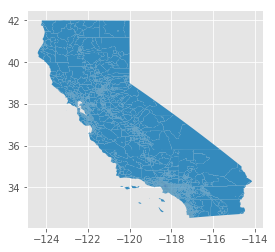

In [6]:
## Census Tracs 
census_tracts = gpd.read_file('../data/cb_2016_06_tract_500k/cb_2016_06_tract_500k.shp')
census_tracts.plot()

In [7]:
census_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,013,359103,1400000US06013359103,06013359103,3591.03,CT,2593523,1170833,"POLYGON ((-122.302287 37.995278, -122.299658 3..."
1,06,013,366001,1400000US06013366001,06013366001,3660.01,CT,1017166,0,"POLYGON ((-122.353307 37.978544, -122.352953 3..."
2,06,013,374000,1400000US06013374000,06013374000,3740,CT,992095,0,"POLYGON ((-122.347509 37.939984, -122.347471 3..."
3,06,013,388000,1400000US06013388000,06013388000,3880,CT,659857,0,"POLYGON ((-122.308489 37.911273, -122.304275 3..."
4,06,017,030710,1400000US06017030710,06017030710,307.10,CT,7898800,0,"POLYGON ((-121.081663 38.692493, -121.079227 3..."


In [8]:
## Zoning Affected 
enriched = gpd.read_file('../data/enriched.geo.json')
enriched.head(5)

,nh,dh,ct,zn,zp,zd,zh,geometry
0,45.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,"POLYGON ((-121.9094202832327 37.3716361135314,..."
1,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,POLYGON ((-121.9173055362167 37.37697169680511...
2,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,"POLYGON ((-121.9167140425162 37.3764636035302,..."
3,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,POLYGON ((-121.9178789922728 37.37724185949239...
4,NaN,NaN,1400000US06085504314,None,NaN,NaN,NaN,"POLYGON ((-121.8518587036548 37.4056524988482,..."


* zn: zone name
* zh: zone height limit
* zp: zone mininum parking per unit
* zd: zone maximum density per acre
* nh: minimum height maximum under SB827
* dh: delta height under SB827

In [9]:
from util import get_dataframe, get_data

In [10]:
enriched['ct_strip'] = enriched['ct'].str[9:]
census_prefix = '14000US'
enriched['geoid'] = enriched['ct_strip'].apply(lambda x: census_prefix + str(x))
del(enriched['ct_strip'])

In [11]:
def get_table_data(tblname, multicolumn=False):
    """
    gets a dataframe from a tablename for our 
    """
    if multicolumn:
        lookup_list = enriched['geoid'].unique()
        i = 0
        raw_data = []
        while i < 2605:
            print("Start Index: ", i)
            step_size = 100
            try:
                raw_data.append(get_data(tables=[tblname], geoids = lookup_list[i:i+step_size]))
            except KeyError:
                pass
            i += step_size
        return raw_data
    lookup_list = enriched['geoid'].unique()
    i = 0
    raw_data = []
    while i < 2605:
        print("Start Index: ", i)
        step_size = 100
        try:
            raw_data.append(get_dataframe(tables=[tblname], geoids = lookup_list[i:i+step_size],col_names=True))
        except KeyError:
            pass
        i += step_size
    df = pd.concat(raw_data)
    return df 
    
affected_tracts_with_data = get_table_data('B08301')
len(affected_tracts_with_data)

Start Index:  0
Start Index:  100
Start Index:  200
Start Index:  300
Start Index:  400
Start Index:  500
Start Index:  600
Start Index:  700
Start Index:  800
Start Index:  900
Start Index:  1000
Start Index:  1100
Start Index:  1200
Start Index:  1300
Start Index:  1400
Start Index:  1500
Start Index:  1600
Start Index:  1700
Start Index:  1800
Start Index:  1900
Start Index:  2000
Start Index:  2100
Start Index:  2200
Start Index:  2300
Start Index:  2400
Start Index:  2500
Start Index:  2600


2505

### Compute `Changescore` 

Changescore is made up of three variables - height change, resident density change and parking change average for normalized by area in a census tract. 


In [12]:
## Compute `Changescore` 

census_parcel_groups = enriched.groupby(['geoid'])

from sklearn import preprocessing

census_parcel_groups_mean = census_parcel_groups.mean().dropna()
min_max_scaler = preprocessing.MinMaxScaler()
census_parcel_groups_mean['dh_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['dh'].reshape(-1, 1))
census_parcel_groups_mean['zd_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['zd'].reshape(-1, 1))
census_parcel_groups_mean['zp_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['zp'].reshape(-1, 1))

/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


In [13]:
changescores = census_parcel_groups_mean['dh_normalized'] + \
               census_parcel_groups_mean['zd_normalized'] + \
               census_parcel_groups_mean['zp_normalized']

In [29]:
change_df = pd.DataFrame({"changescores": changescores, 
                          "normalized": min_max_scaler.fit_transform(changescores.values.reshape(-1,1)).tolist()})
change_df["normalized"] = change_df['normalized'].apply(lambda x: x[0])
change_df.describe()

,changescores,normalized
count,1.311000e+03,1311.000000
mean,1.044698e+00,0.626819
std,2.501151e-01,0.150069
min,1.160237e-07,0.000000
25%,9.345263e-01,0.560716
50%,1.042369e+00,0.625421
75%,1.142492e+00,0.685495
max,1.666667e+00,1.000000


In [38]:
change_df.max()

changescores    1.666667
normalized      1.000000
dtype: float64

In [15]:
## Join to the affect tracts 
df = affected_tracts_with_data.join(change_df, how='inner')
## Didn't Drive Alone
df['not_alone'] = df.apply(lambda x: x['Total:'] - x['Drove alone'], axis=1)
df['not_alone_percent'] = df.apply(lambda x: x['not_alone'] / x['Total:'], axis=1)

/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [31]:
df.reset_index().to_feather('../outputs/changescores.feather')

In [51]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
df[['not_alone_percent','normalized']].head()

,not_alone_percent,normalized
14000US06037106010,0.191446,0.474105
14000US06037106020,0.172209,0.568571
14000US06037106111,0.240741,0.401099
14000US06037106406,0.336398,0.635051
14000US06075010100,0.764569,0.646257


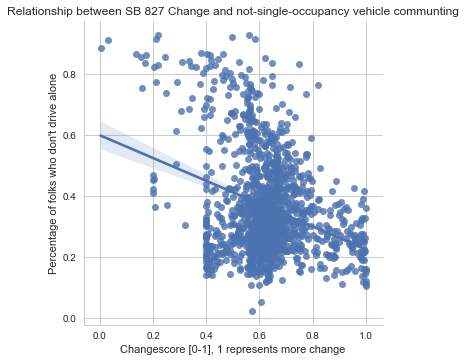

In [55]:
# Plot tip as a function of toal bill across days
g = sns.lmplot(x="normalized", y="not_alone_percent",
               truncate=True, size=5, data=df)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Changescore [0-1], 1 represents more change", "Percentage of folks who don't drive alone")

ax = plt.gca()
ax.set_title("Relationship between SB 827 Change and not-single-occupancy vehicle communting")
g.savefig('../outputs/proof.png')

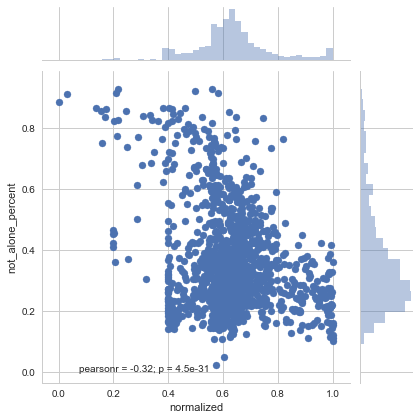

In [53]:
# Plot tip as a function of toal bill across days
g = sns.jointplot("normalized", "not_alone_percent", data=df)


In [19]:
df['ratio'] = df.not_alone_percent % df.changescores 

Text(0.5,1,'Relationship between SB 827 Change and not-single-occupancy vehicle communting')

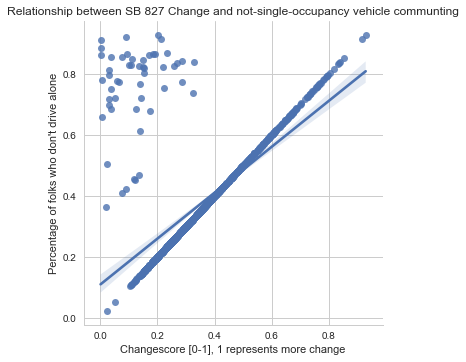

In [54]:
# Plot tip as a function of toal bill across days
g = sns.lmplot(x="ratio", y="not_alone_percent",
               truncate=True, size=5, data=df)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Changescore [0-1], 1 represents more change", "Percentage of folks who don't drive alone")

ax = plt.gca()
ax.set_title("Relationship between SB 827 Change and not-single-occupancy vehicle communting")

In [21]:
census_tracts['GEOID_OLD'] = census_tracts.GEOID.apply(lambda x: census_prefix + str(x))

In [22]:
gdf = gpd.GeoDataFrame(df.join(census_tracts.set_index('GEOID_OLD'), how='inner'))
gdf.to_file('../data/changescores.geojson', driver='GeoJSON')

DriverIOError: GeoJSON driver doesn't support creating a layer on a read-only datasource

In [ ]:
## what if we test for income

In [ ]:
income_data = get_table_data('B08119', multicolumn=True)

In [50]:
df['not_alone_percent'].sort_values(ascending=False)

14000US06075011700    0.929134
14000US06075012100    0.928060
14000US06037209402    0.921105
14000US06075011800    0.914483
14000US06037206300    0.914481
14000US06075012202    0.912812
14000US06075012000    0.885009
14000US06075015500    0.867330
14000US06075010700    0.866741
14000US06075011100    0.866493
14000US06075061100    0.864719
14000US06037208902    0.861860
14000US06075011901    0.861272
14000US06075011902    0.857215
14000US06075011300    0.855876
14000US06075033201    0.853186
14000US06075016900    0.849946
14000US06037222700    0.847134
14000US06075017601    0.842493
14000US06075017801    0.840351
14000US06075022901    0.838174
14000US06075020100    0.837319
14000US06075060700    0.836682
14000US06075020800    0.832266
14000US06037265301    0.829961
14000US06075015100    0.827829
14000US06075016200    0.825968
14000US06075016802    0.825102
14000US06075011200    0.823499
14000US06075018000    0.823174
                        ...   
14000US06073008513    0.145011
14000US0